In [1]:
import random, math
import numpy as np
import pandas as pd
from Bio import SeqIO

# custom packages
import wgregseq

import sys
sys.path.insert(1, '../scripts')
import simulate_seq as ss
import footprint as fp
import footprint_to_sites as f2s

# visualization
import matplotlib.pyplot as plt
import seaborn as sns

## Computing p_bound for simple activation

In [2]:
def simact_pbound(e_ap, n_p, n_a, n_NS):
    
    a_weight = n_a / n_NS * np.exp(13.12)
    _f_reg = 1 + a_weight
    f_reg = (1 + a_weight * np.exp(- e_ap)) / _f_reg
    _pbound = 1 + n_NS / (n_p * f_reg) * np.exp(5.3)
    pbound = 1 / _pbound
    return pbound

In [3]:
for record in SeqIO.parse("../../data/mg1655_genome.fasta", "fasta"):
    n_NS = len(record.seq)

In [4]:
n_a = np.arange(0, 100)
pbound3 = []
pbound4 = []
pbound5 = []
for i in n_a:
    pbound3.append(simact_pbound(-3, 500, i, n_NS))
    pbound4.append(simact_pbound(-4, 500, i, n_NS))
    pbound5.append(simact_pbound(-5, 500, i, n_NS))

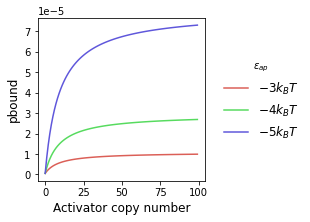

In [5]:
fig, ax = plt.subplots(figsize=(3,3))

colors = sns.color_palette("hls", 3)

ax.plot(n_a, pbound3, color=colors[0])
ax.plot(n_a, pbound4, color=colors[1])
ax.plot(n_a, pbound5, color=colors[2])
ax.set_xlabel('Activator copy number', fontsize=12)
ax.set_ylabel('pbound', fontsize=12)
ax.legend(['$-3 k_BT$', '$-4 k_BT$', '$-5 k_BT$'],
          title=r'$\varepsilon_{ap}$', fontsize=12,
          bbox_to_anchor=(1.05, 0.8), frameon=False)
plt.savefig('./plots/simact.png', dpi=300, bbox_inches='tight')
plt.show()

Here we use groSL as a case study for simple activation

## Identify binding sites

In [5]:
df = pd.read_csv('~/rpgroup/RegSeq/data/information_footprints/groSLheatdatasetinfofootprint.txt', delim_whitespace=True)

In [6]:
raw_info = df['info']

bsites = f2s.find_binding_sites(raw_info)
bsites

[(76, 82), (96, 105)]

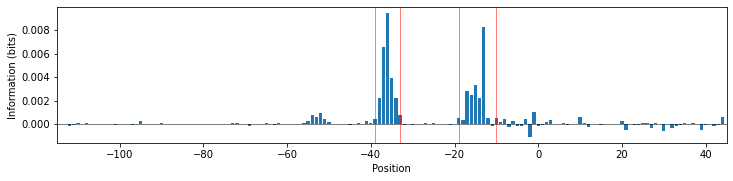

In [8]:
fig, ax = plt.subplots(figsize=(12, 2.5))

ax.bar(np.arange(-115, 45), df['info'])
ax.set_ylabel('Information (bits)')
ax.set_xlabel('Position')
ax.axhline(0, color='black', linewidth=0.5)
for i in [76, 82, 96, 105]:
    ax.axvline(i-115, color='red', linewidth=0.5)
ax.set_xlim(-115, 45)
plt.show()

## Identify and annotate regulatory region

In [7]:
_genome = []
for record in SeqIO.parse("../../data/mg1655_genome.fasta", "fasta"):
    _genome.append(str(record.seq))
genome = _genome[0]

In [8]:
df = pd.read_csv('../../data/ecoli_gene_list.csv')
df[df.gene == 'groS']

,gene,promoter,gene_position,direction,tss,evidence
1865,groS,groSp,4370688.0,+,4370616.0,"[""COMP"", ""COMP"", ""COMP"", ""COMP"", ""EXP"", ""EXP"",..."
1867,groS,groSp2,4370688.0,+,4370616.0,"[""COMP"", ""COMP"", ""COMP"", ""COMP"", ""EXP"", ""EXP"",..."


In [9]:

groSL_TSS = int(df[(df.gene == 'groS') & (df.promoter == 'groSp')]['tss'].iloc[0])
groSL_TSS

4370616

In [10]:
groSL = ss.get_regulatory_region(genome, groSL_TSS)
groSL

'AAATTGCGATGAAATGTGAGGTGAATCAGGGTTTTCACCCGATTTTGTGCTGATCAGAATTTTTTTTCTTTTTCCCCCTTGAAGGGGCGAAGCCTCATCCCCATTTCTCTGGTCACCAGCCGGGAAACCACGTAAGCTCCGGCGTCACCCATAACAGATA'

## Load energy matrices

In [11]:
# Import full energy matrix

df_emat = pd.read_csv('~/rpgroup/regseq_all_matrices/groSLheatdataset_alldone_with_largeMCMC195', delim_whitespace=True)
emat = df_emat[['val_A', 'val_C', 'val_G', 'val_T']][:160].to_numpy().T

In [12]:
act_start, act_end = bsites[0]
rnap_start, rnap_end = bsites[1]

In [13]:
groSL[76:83]

'CCTTGAA'

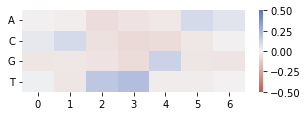

In [14]:
div_colors = sns.diverging_palette(16, 258, s=56, l=51, n=15, sep=2, center='light', as_cmap=True)

fig, ax = plt.subplots(figsize=(5, 1.5))
a_emat = emat[:, 76:83]
sns.heatmap(a_emat, cmap=div_colors, ax=ax, vmin=-.5, vmax=.5)
ax.set_yticklabels(['A', 'C', 'G', 'T'], rotation=360)
plt.show()

In [15]:
groSL[96:106]

'ATCCCCATTT'

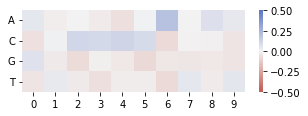

In [16]:
fig, ax = plt.subplots(figsize=(5, 1.5))
p_emat = emat[:, 96:106]
sns.heatmap(p_emat, cmap=div_colors, ax=ax, vmin=-.5, vmax=.5)
ax.set_yticklabels(['A', 'C', 'G', 'T'], rotation=360)
plt.show()

## Generate mutated sequences

In [17]:
groSL_mutants = np.unique(wgregseq.mutations_rand(groSL, rate=0.1, num_mutants=100000, number_fixed=True))

In [18]:
n_p = 1500
n_a = 50
e_ap = -20

In [19]:
l_tr = []
for mut in groSL_mutants:
    rv = {}
    rv['seq'] = mut
    rnap_mut = mut[rnap_start:rnap_end].upper()
    act_mut = mut[act_start:act_end].upper()
    rv['pbound'] = ss.simact_pbound(rnap_mut, act_mut, -p_emat, -a_emat, e_ap, n_p, n_a, n_NS)
    l_tr.append(rv)

In [20]:
df_tr = pd.DataFrame.from_records(l_tr)
df_tr.head()

,seq,pbound
0,AAATTGCGATGAAATGTGAGGTGAATCAGGGTTTTCACCCGATTTT...,0.854657
1,AAATTGCGATGAAATGTGAGGTGAATCAGGGTTTTCACCCGATTTT...,0.801324
2,AAATTGCGATGAAATGTGAGGTGAATCAGGGTTTTCACCCGATTTT...,0.820647
3,AAATTGCGATGAAATGTGAGGTGAATCAGGGTTTTCACCCGATTTT...,0.847487
4,AAATTGCGATGAAATGTGAGGTGAATCAGGGTTTTCACCCGATTTT...,0.809516


## Generate sequence counts using exponential distribution

In [21]:
dna_cnt = np.random.exponential(1, size=len(df_tr)) * 10

In [22]:
dna_cnt_up = []
for cnt in dna_cnt:
    dna_cnt_up.append(math.ceil(cnt))

In [23]:
df_tr['ct_0'] = dna_cnt_up
df_tr['ct_1'] = df_tr['ct_0'] * df_tr['pbound']
df_tr['ct_1'] = df_tr['ct_1'].astype(int)
df_tr['ct'] = df_tr['ct_0'] + df_tr['ct_1']

In [24]:
df_tr['ct'] = df_tr['ct'].astype(float)
df_tr['ct_0'] = df_tr['ct_0'].astype(float)
df_tr['ct_1'] = df_tr['ct_1'].astype(float)

In [25]:
df_tr.head()

,seq,pbound,ct_0,ct_1,ct
0,AAATTGCGATGAAATGTGAGGTGAATCAGGGTTTTCACCCGATTTT...,0.854657,2.0,1.0,3.0
1,AAATTGCGATGAAATGTGAGGTGAATCAGGGTTTTCACCCGATTTT...,0.801324,3.0,2.0,5.0
2,AAATTGCGATGAAATGTGAGGTGAATCAGGGTTTTCACCCGATTTT...,0.820647,7.0,5.0,12.0
3,AAATTGCGATGAAATGTGAGGTGAATCAGGGTTTTCACCCGATTTT...,0.847487,2.0,1.0,3.0
4,AAATTGCGATGAAATGTGAGGTGAATCAGGGTTTTCACCCGATTTT...,0.809516,15.0,12.0,27.0


In [26]:
df_tr.to_csv('../../data/synthetic_datasets/groSL_synthetic_dataset.csv', index=False)

## Information footprint

In [27]:
fpath = '../../data/synthetic_datasets/groSL_synthetic_dataset.csv'

df_groSL = pd.read_csv(fpath)
df_groSL.head()

,seq,pbound,ct_0,ct_1,ct
0,AAATTGCGATGAAATGTGAGGTGAATCAGGGTTTTCACCCGATTTT...,0.854657,2.0,1.0,3.0
1,AAATTGCGATGAAATGTGAGGTGAATCAGGGTTTTCACCCGATTTT...,0.801324,3.0,2.0,5.0
2,AAATTGCGATGAAATGTGAGGTGAATCAGGGTTTTCACCCGATTTT...,0.820647,7.0,5.0,12.0
3,AAATTGCGATGAAATGTGAGGTGAATCAGGGTTTTCACCCGATTTT...,0.847487,2.0,1.0,3.0
4,AAATTGCGATGAAATGTGAGGTGAATCAGGGTTTTCACCCGATTTT...,0.809516,15.0,12.0,27.0


In [28]:
wtseq = groSL

<AxesSubplot:xlabel='position', ylabel='Information (bits)'>

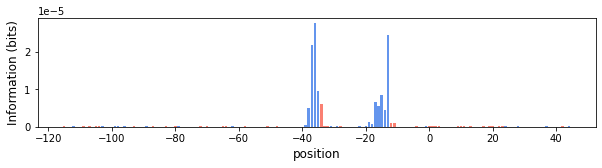

In [29]:
fp.plot_mi_footprint(fpath, wtseq, color=True, output_file='./fig.png')

<AxesSubplot:xlabel='position', ylabel='Information (bits)'>

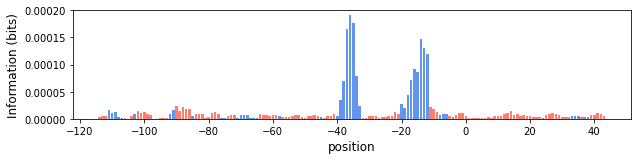

In [32]:
fp.plot_linreg_footprint(fpath, wtseq, pseudocount=0.5)